In [1]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client
import geopandas as gpd
import requests

from odc.stac import configure_rio, stac_load
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


In [2]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34363,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.45 GiB
Comm: tcp://127.0.0.1:48765,Total threads: 3
Dashboard: http://127.0.0.1:48777/status,Memory: 3.86 GiB
Nanny: tcp://127.0.0.1:39663,


2024-09-12 19:26:36,762 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:35039 (pid=248894) exceeded 95% memory budget. Restarting...
2024-09-12 19:26:36,998 - distributed.nanny - WARNING - Restarting worker
2024-09-12 19:27:07,164 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:37111 (pid=248897) exceeded 95% memory budget. Restarting...
2024-09-12 19:27:07,334 - distributed.nanny - WARNING - Restarting worker
2024-09-12 19:27:33,266 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2024-09-12 19:27:33,267 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing


In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=pc.sign_inplace)
hel_mel = gpd.read_file('/media/laserglaciers/upernavik/iceberg_py/geoms/helheim/melange_box.shp')


query = catalog.search(
    collections=["sentinel-2-l2a"],
    datetime="2016-05",
    query={"s2:mgrs_tile": dict(eq="24WWU"),
          "eo:cloud_cover": {"lt": 10}},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 6 datasets


In [4]:
hel_mel

,id,geometry
0,None,"POLYGON ((532539.637 7353466.439, 533799.457 7..."


In [5]:
resolution = 10
SHRINK = 1
if client.cluster.workers[0].memory_manager.memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # running on Binder with 2Gb RAM

if SHRINK > 1:
    resolution = resolution * SHRINK

xx = stac_load(
    items,
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    resolution=resolution,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 23GB
Dimensions:      (y: 10980, x: 10980, time: 6)
Coordinates:
  * y            (y) float64 88kB 7.4e+06 7.4e+06 7.4e+06 ... 7.29e+06 7.29e+06
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32624
  * time         (time) datetime64[ns] 48B 2016-05-04T14:20:12.027000 ... 201...
Data variables: (12/16)
    AOT          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B01          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B02          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B03          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B04          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B05          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B12          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    B8A          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    SCL          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    WVP          (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    visual       (time, y, x) uint16 1GB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

In [6]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir"],
    resolution=resolution,
    chunks={},
    patch_url=pc.sign,
    # force dtype and nodata
    dtype="uint16",
    nodata=0
    # geopolygon=hel_mel
)

print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)

Bands: red,green,blue,nir


<xarray.Dataset> Size: 6GB
Dimensions:      (y: 10980, x: 10980, time: 6)
Coordinates:
  * y            (y) float64 88kB 7.4e+06 7.4e+06 7.4e+06 ... 7.29e+06 7.29e+06
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
    spatial_ref  int32 4B 32624
  * time         (time) datetime64[ns] 48B 2016-05-04T14:20:12.027000 ... 201...
Data variables:
    red          (time, y, x) uint16 1GB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    green        (time, y, x) uint16 1GB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    blue         (time, y, x) uint16 1GB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>
    nir          (time, y, x) uint16 1GB dask.array<chunksize=(1, 10980, 10980), meta=np.ndarray>

In [7]:
def to_float(xx):
    _xx = xx.astype("float32")
    nodata = _xx.attrs.pop("nodata", None)
    if nodata is None:
        return _xx
    return _xx.where(xx != nodata)


def colorize(xx, colormap):
    return xr.DataArray(colormap[xx.data], coords=xx.coords, dims=(*xx.dims, "band"))

In [8]:
# like .astype(float32) but taking care of nodata->NaN mapping
nir = to_float(xx.nir)
red = to_float(xx.red)
ndvi = (nir - red) / (
    nir + red
)  # < This is still a lazy Dask computation (no data loaded yet)

# Get the 5-th time slice `load->compute->plot`
_ = ndvi.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

2024-09-12 19:26:35,976 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 3.18 GiB -- Worker memory limit: 3.86 GiB
2024-09-12 19:26:36,258 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.48 GiB -- Worker memory limit: 3.86 GiB
2024-09-12 19:27:06,903 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 3.33 GiB -- Worker memory limit: 3.86 GiB
2024-09-12 19:27:06,903 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

KeyboardInterrupt: 

2024-09-12 19:27:17,063 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2024-09-12 19:27:17,064 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/home/laserglaciers/anaconda3/envs/py310v2/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/laserglaciers/anaconda3/envs/py310v2/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/laserglaciers/anaconda3/envs/py310v2/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/home/laserglaciers/anaconda3/envs/py310v2/lib/python3.10/site-packages/distributed/nanny.py", line 1021, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/home/laserglaciers/anaconda3/envs/py310v2/lib/python3.10/site-packages/distri

KeyboardInterrupt: 

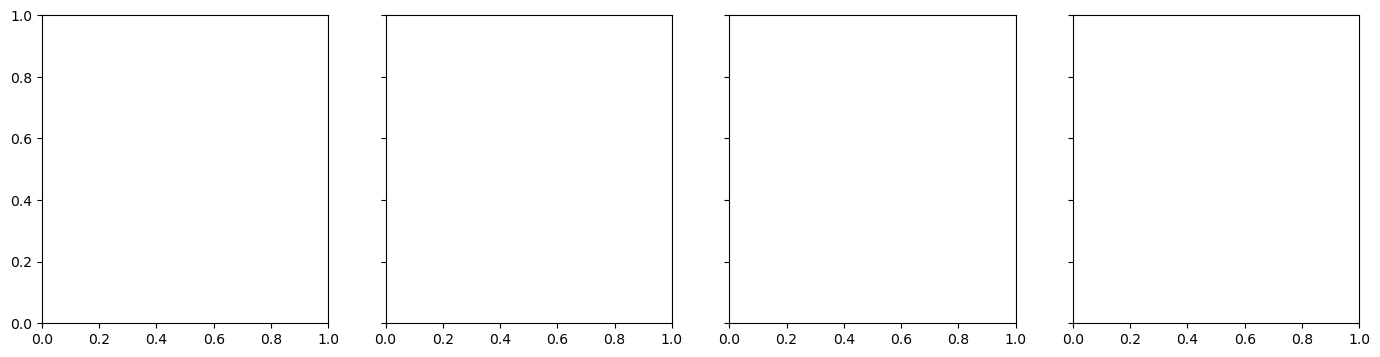

In [9]:
# xx.isel(time=4).compute().plot.imshow(size=7, aspect=1.2, interpolation="bicubic")

_ = (
    xx.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)


In [10]:
time=0
rgb = np.dstack((xx.red.isel(time=time).values,
                 xx.green.isel(time=time).values,
                 xx.blue.isel(time=time).values))
# Normalize the RGB data
rgb_norm = rgb / rgb.max()

# Display the normalized RGB image using plt.imshow
plt.imshow(rgb_norm)

Task exception was never retrieved
future: <Task finished name='Task-19187' coro=<Client._gather.<locals>.wait() done, defined at /home/laserglaciers/anaconda3/envs/py310v2/lib/python3.10/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/home/laserglaciers/anaconda3/envs/py310v2/lib/python3.10/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [ ]:
xx.isel(time=0).odc.affine

In [ ]:
items[0].assets['B02'].href

In [ ]:
requests.head(items[0].assets['B02'].href).status_code


In [ ]:
import rasterio.plot
with rasterio.open(items[0].assets['B02'].href) as dataset:
    rasterio.plot.show(dataset)

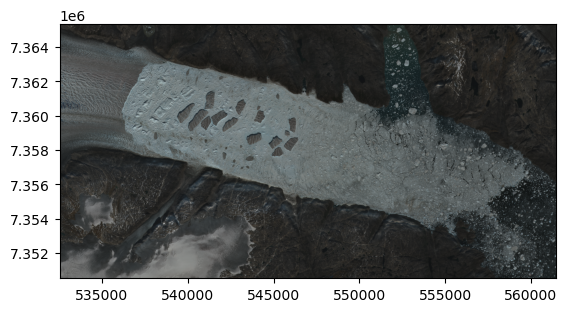

<Axes: >

In [18]:
from rasterio.plot import show
import numpy as np

affine = xx.red.isel(time=time).odc.affine

#better for rasterio?
t = np.moveaxis(rgb_norm.T,1,-1)
show(t, transform=affine)

In [20]:
from rasterio.features import geometry_mask, geometry_window

In [21]:
grid_path = '/media/laserglaciers/upernavik/iceberg_py/geoms/helheim/3x6_grid.shp'
grid = gpd.read_file(grid_path)
grid.geometry

0     POLYGON ((307795.677 -2575064.962, 310795.677 ...
1     POLYGON ((307795.677 -2581064.962, 310795.677 ...
2     POLYGON ((310795.677 -2575064.962, 313795.677 ...
3     POLYGON ((310795.677 -2581064.962, 313795.677 ...
4     POLYGON ((313795.677 -2575064.962, 316795.677 ...
5     POLYGON ((313795.677 -2581064.962, 316795.677 ...
6     POLYGON ((316795.677 -2575064.962, 319795.677 ...
7     POLYGON ((316795.677 -2581064.962, 319795.677 ...
8     POLYGON ((319795.677 -2575064.962, 322795.677 ...
9     POLYGON ((319795.677 -2581064.962, 322795.677 ...
10    POLYGON ((322795.677 -2575064.962, 325795.677 ...
11    POLYGON ((322795.677 -2581064.962, 325795.677 ...
12    POLYGON ((325795.677 -2575064.962, 328795.677 ...
13    POLYGON ((325795.677 -2581064.962, 328795.677 ...
14    POLYGON ((328795.677 -2575064.962, 331795.677 ...
15    POLYGON ((328795.677 -2581064.962, 331795.677 ...
16    POLYGON ((331795.677 -2575064.962, 334795.677 ...
17    POLYGON ((331795.677 -2581064.962, 334795.

In [27]:
from contextlib import contextmanager  
import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
from rasterio.windows import Window
import cv2

In [28]:
#https://rasterio.groups.io/g/main/topic/memoryfile_workflow_should/32634761
@contextmanager
def mem_raster(data, **profile):
    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset_writer:
            dataset_writer.write(data)
 
        with memfile.open() as dataset_reader:
            yield dataset_reader

profile_t = {'driver':'GTiff', 'count':3, 
                      'transform':affine, 'crs':32624, 
                      'width':t.shape[2], 'height': t.shape[1], 
                      'dtype':np.float64
}

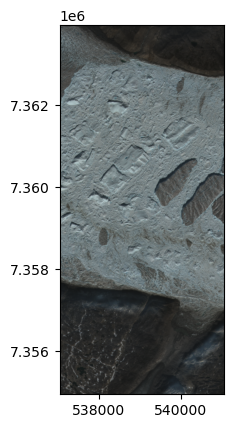

In [29]:
grid2_path = '/media/laserglaciers/upernavik/iceberg_py/geoms/helheim/melange_box_grid_utm24.shp'
grid2 = gpd.read_file(grid2_path)
with mem_raster(t, **profile_t) as ds:
    window = geometry_window(ds, [grid2.geometry[1]])
    w = ds.read([1,2,3], window=window)
    win_transform = ds.window_transform(window)
    # show(ds.read([1,2,3]))
    
    # b1 = ds.read(1)
    # b2 = ds.read(2)
    # b3 = ds.read(3)
    show(w,transform=win_transform)

In [30]:
def cv2Norm(band):
    img_u8 = cv2.normalize(band, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    
    return img_u8
cv2Norm(w)

array([[[66, 67, 66, ..., 20, 18, 19],
        [74, 75, 79, ..., 17, 16, 17],
        [75, 77, 83, ..., 19, 18, 17],
        ...,
        [41, 36, 30, ..., 13, 15, 14],
        [36, 33, 29, ..., 22, 24, 22],
        [40, 37, 32, ..., 25, 25, 24]],

       [[69, 73, 66, ..., 22, 18, 18],
        [80, 79, 79, ..., 18, 16, 16],
        [82, 78, 91, ..., 17, 18, 17],
        ...,
        [39, 36, 30, ..., 12, 14, 15],
        [32, 33, 31, ..., 20, 22, 19],
        [36, 34, 30, ..., 24, 25, 24]],

       [[71, 77, 65, ..., 19, 17, 15],
        [81, 77, 78, ..., 15, 14, 15],
        [79, 77, 89, ..., 16, 17, 16],
        ...,
        [32, 30, 27, ..., 14, 13, 13],
        [26, 28, 26, ..., 19, 21, 19],
        [32, 32, 27, ..., 21, 22, 21]]], dtype=uint8)

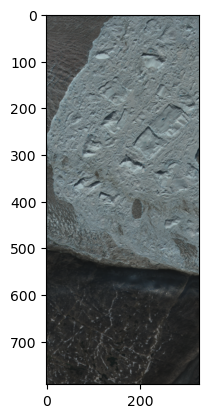

In [57]:
w2 = np.moveaxis(w,0,-1)

plt.imshow(w2)

In [61]:
from segment_anything import SamPredictor, SamAutomaticMaskGenerator,sam_model_registry

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import torch

In [62]:
FEATURE_OF_INTEREST = 'icebergs' #icebergs,crevasse,terminus,supraglacial_lakes,planet, sentinel-2, sentinel-1, timelapse
MODEL_TYPE = 'vit_h'
MODEL_WEIGHTS = 'sam_vit_h_4b8939.pth' # sam_vit_b_01ec64.pth,sam_vit_h_4b8939.pth,sam_vit_l_0b3195.pth
OUTPUT_FOLDER = 'predict_no_prompt' # predict_with_prompt, predict_no_prompt

BASE_PATH = f'/media/laserglaciers/upernavik/Helheim_ortho_photos/ortho_images/jpgs/'
# OUTPUT_PATH = os.path.join(BASE_PATH,'%s'%(OUTPUT_FOLDER))
OUTPUT_PATH = f'{BASE_PATH}/OUTPUT_FOLDER'
fileName = '7P14_M42_A4545V_239_ortho.jpg'

In [63]:
sam = sam_model_registry["%s"%(MODEL_TYPE)](checkpoint="/media/laserglaciers/upernavik/segment-anything/models/%s"%(MODEL_WEIGHTS))

In [64]:
# device = "cuda"
# sam.to(device=device)

In [65]:
predictor = SamPredictor(sam)
predictor.set_image(w2)

In [94]:
mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(w2)
out_path = '/media/laserglaciers/upernavik/iceberg_py/outfiles/helheim/sam_output/2023_07_27.png'
if FEATURE_OF_INTEREST == 'terminus':
    for num in range(len(masks)):
        im = Image.fromarray(masks[num]['segmentation'])
        im.save(f'{OUTPUT_PATH}/{fileName.split(".")[0]}{num}_predict.png')

else:
    binary_pred_zeros = np.zeros_like(masks[1]['segmentation'])
    for num in range(len(masks)):
        # 25% or higher number of pixels are True, that means it is a potential representation of background
        # and not of icebergs
        if np.count_nonzero(masks[num]['segmentation'])>(0.25*(masks[num]['segmentation']).size):
            continue
        else:               
            binary_pred_zeros[masks[num]['segmentation']==1]=1
    im = Image.fromarray(binary_pred_zeros)
    # im.save(f'{OUTPUT_PATH}/{fileName.split(".")[0]}_predict_{MODEL_TYPE}.png')
    im.save(f'{out_path}')


In [92]:
date = xx.red.isel(time=time).time.dt.date.compute()
xx

array(datetime.date(2023, 7, 27), dtype=object)

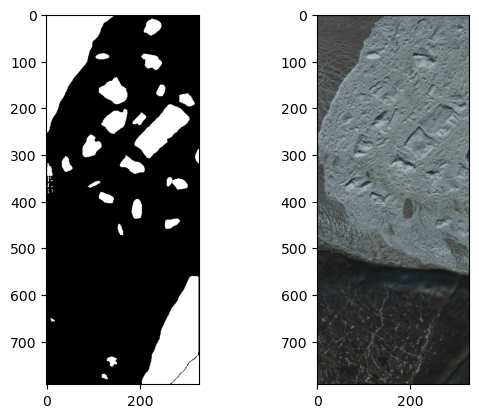

In [98]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(w2)

In [101]:
im.save('/media/laserglaciers/upernavik/iceberg_py/outfiles/helheim/sam_output/test.png',"PNG")

In [100]:
type(im)

PIL.Image.Image

In [ ]:
im.